In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import sklearn

a. Image processing
==

During this step, the following occurs:
 1. Resizing to 64x64 for all images
 2. Saving the 64x64 files to a separate directory named "edited"


Observations and experimentation:
64x64 as first pass
first image as 4 as 3rd param. (RGBA: transparency. need to see how to drop it, convert to rgb isn't enough)
8th image no 3rd param.
does not contain apple_34.
use grayscale images instead of color?

In [49]:
from os.path import isfile

edited_path = "edited/"
class_names = ['apple', 'banana', 'mixed', 'orange']

# write a function to create the directory automatically,
# if dir exists, do not create the dir
def process_image(i, name, img_path):
    file_name = img_path + "{0}_{1}.jpg".format(name, i)
    if isfile(file_name):
        img = Image.open(file_name)
        img_64 = img.resize((64,64))
        if img_64.mode in ["RGBA", "P"]:
            img_64 = img_64.convert("RGB")

        img_64.save(img_path + edited_path + "{0}_{1}_64x64.jpg".format(name,i))

In [50]:
# can modify later to pass in dictionary of name and number of images.
for path in ["train/","test/"]:
    for i in range(1,96):
        process_image(i, "apple", path)
        process_image(i, "orange",path)
        process_image(i, "banana", path)
        process_image(i, "mixed", path)

/Users/xinyitay/miniforge3/envs/gdiptf/lib/python3.8/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [51]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#
# def create_arr(i, name):
#     if isfile(file_name):
#         img = load_img(img_path_train + edited_path + "{0}_{1}_64x64.jpg".format(name,i))
#         img_arr = img_to_array(img)
#         img_arr.reshape((-1,64,64))
# validation_datagen = ImageDataGenerator(rescale=1./255)

b. Creating train and test arrays
==
During this step, the following occurs:
 1. Reading 64x64 image data
 2. Creating labels for the data based on image name
 3. Concatenating the images and storing them in our train dataset
 4. Storing label data in our test array


In [52]:
train_img = []
train_class = []
test_img = []
test_class = []

def create_arr(i, name, path):
    file_name = path + edited_path + "{0}_{1}_64x64.jpg".format(name, i)
    if isfile(file_name):
        img = Image.open(file_name)
        img_arr = np.array(img)
        if path == "train/":
            train_img.append(img_arr)
            train_class.append(name)
        if path == "test/":
            test_img.append(img_arr)
            test_class.append(name)

In [53]:
for path in ["train/","test/"]:
    for i in range(1,96):
        create_arr(i, "apple", path)
        create_arr(i, "orange",path)
        create_arr(i, "banana", path)
        create_arr(i, "mixed", path)

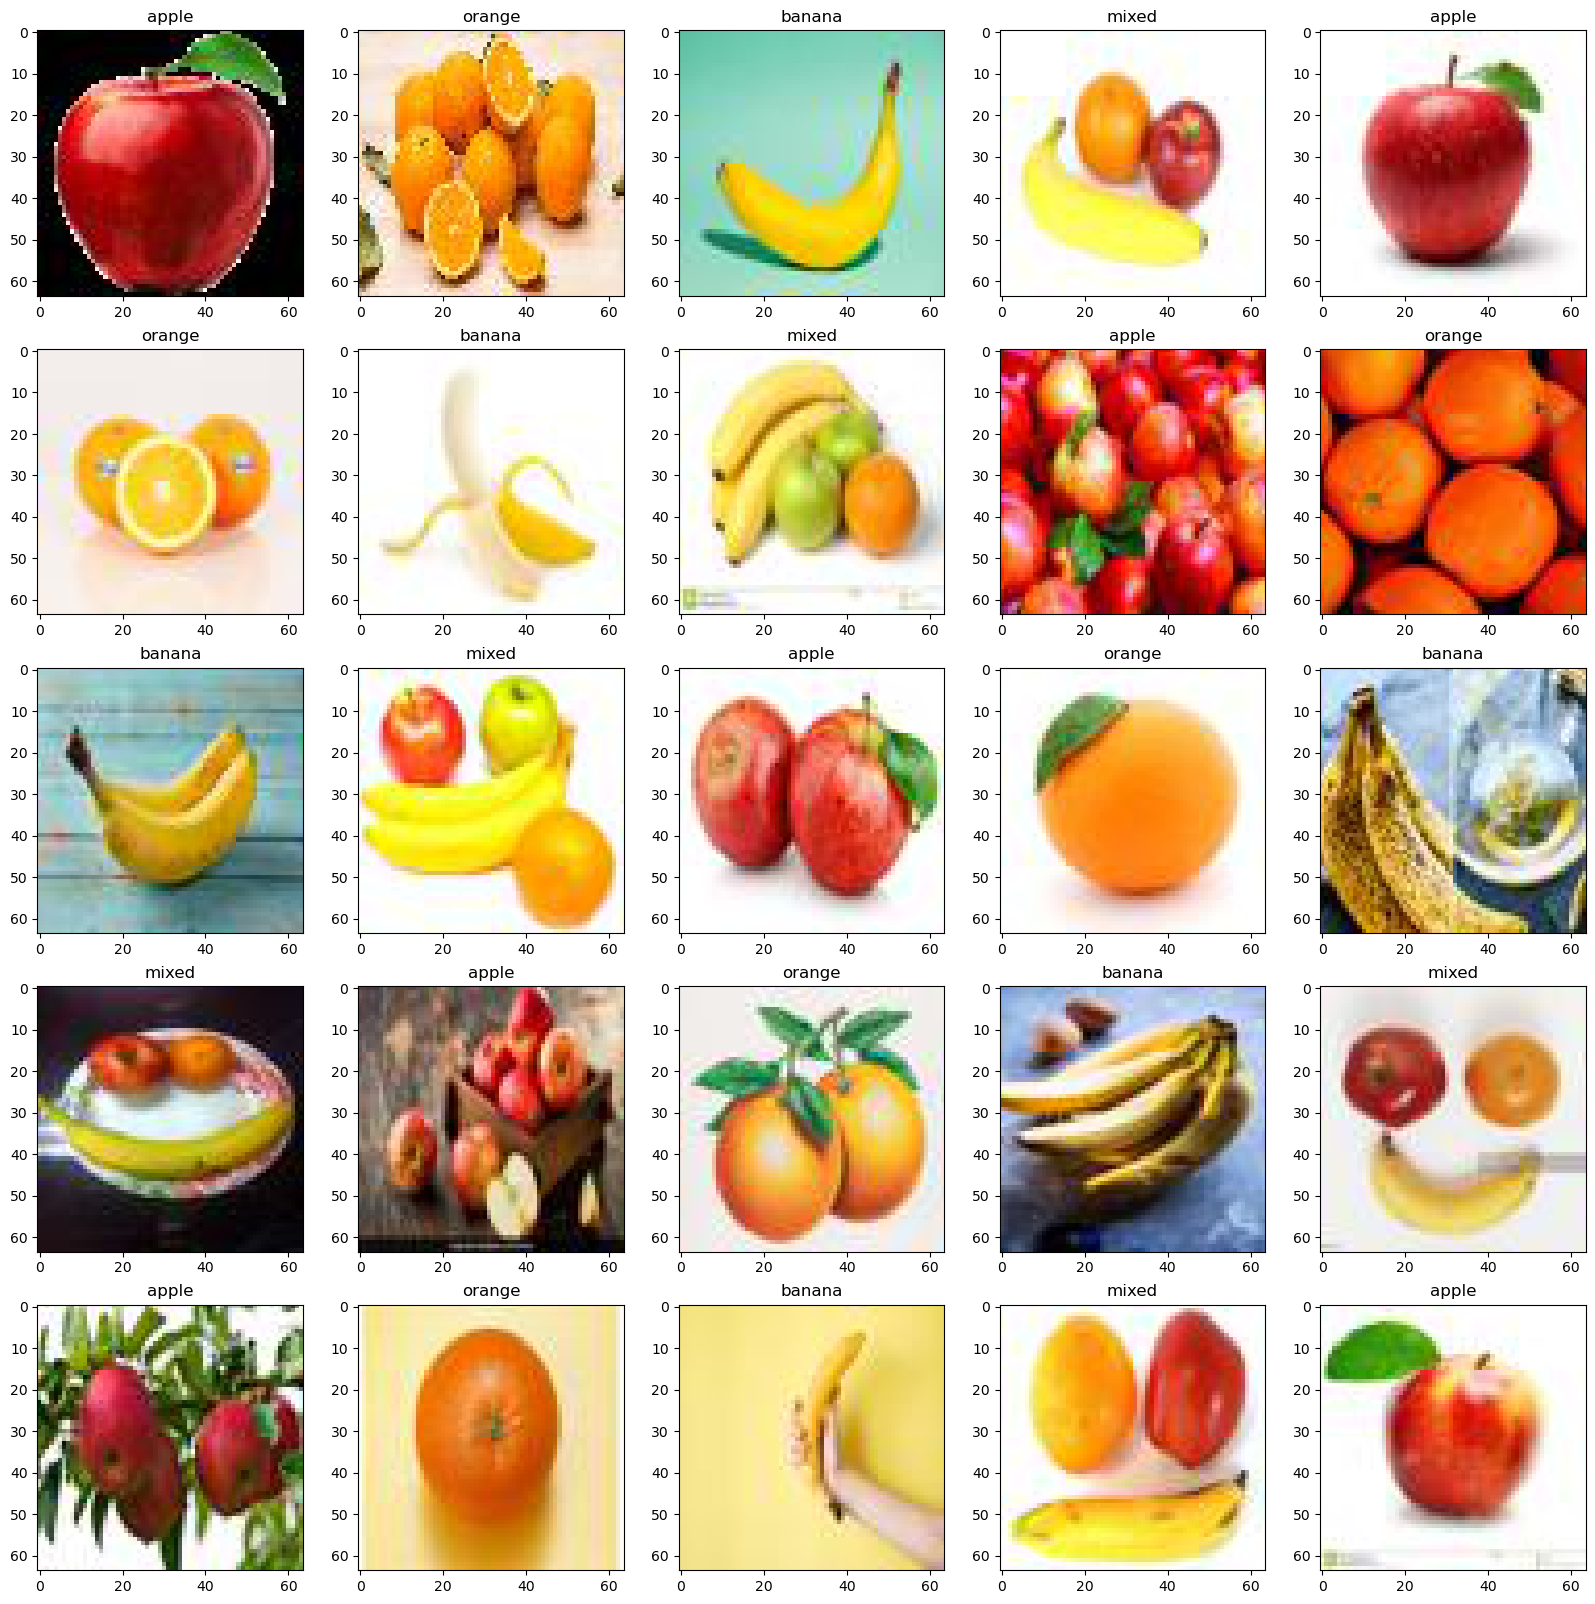

In [100]:
# preview for train images
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(train_img[i])
    plt.title(train_class[i])
plt.show()

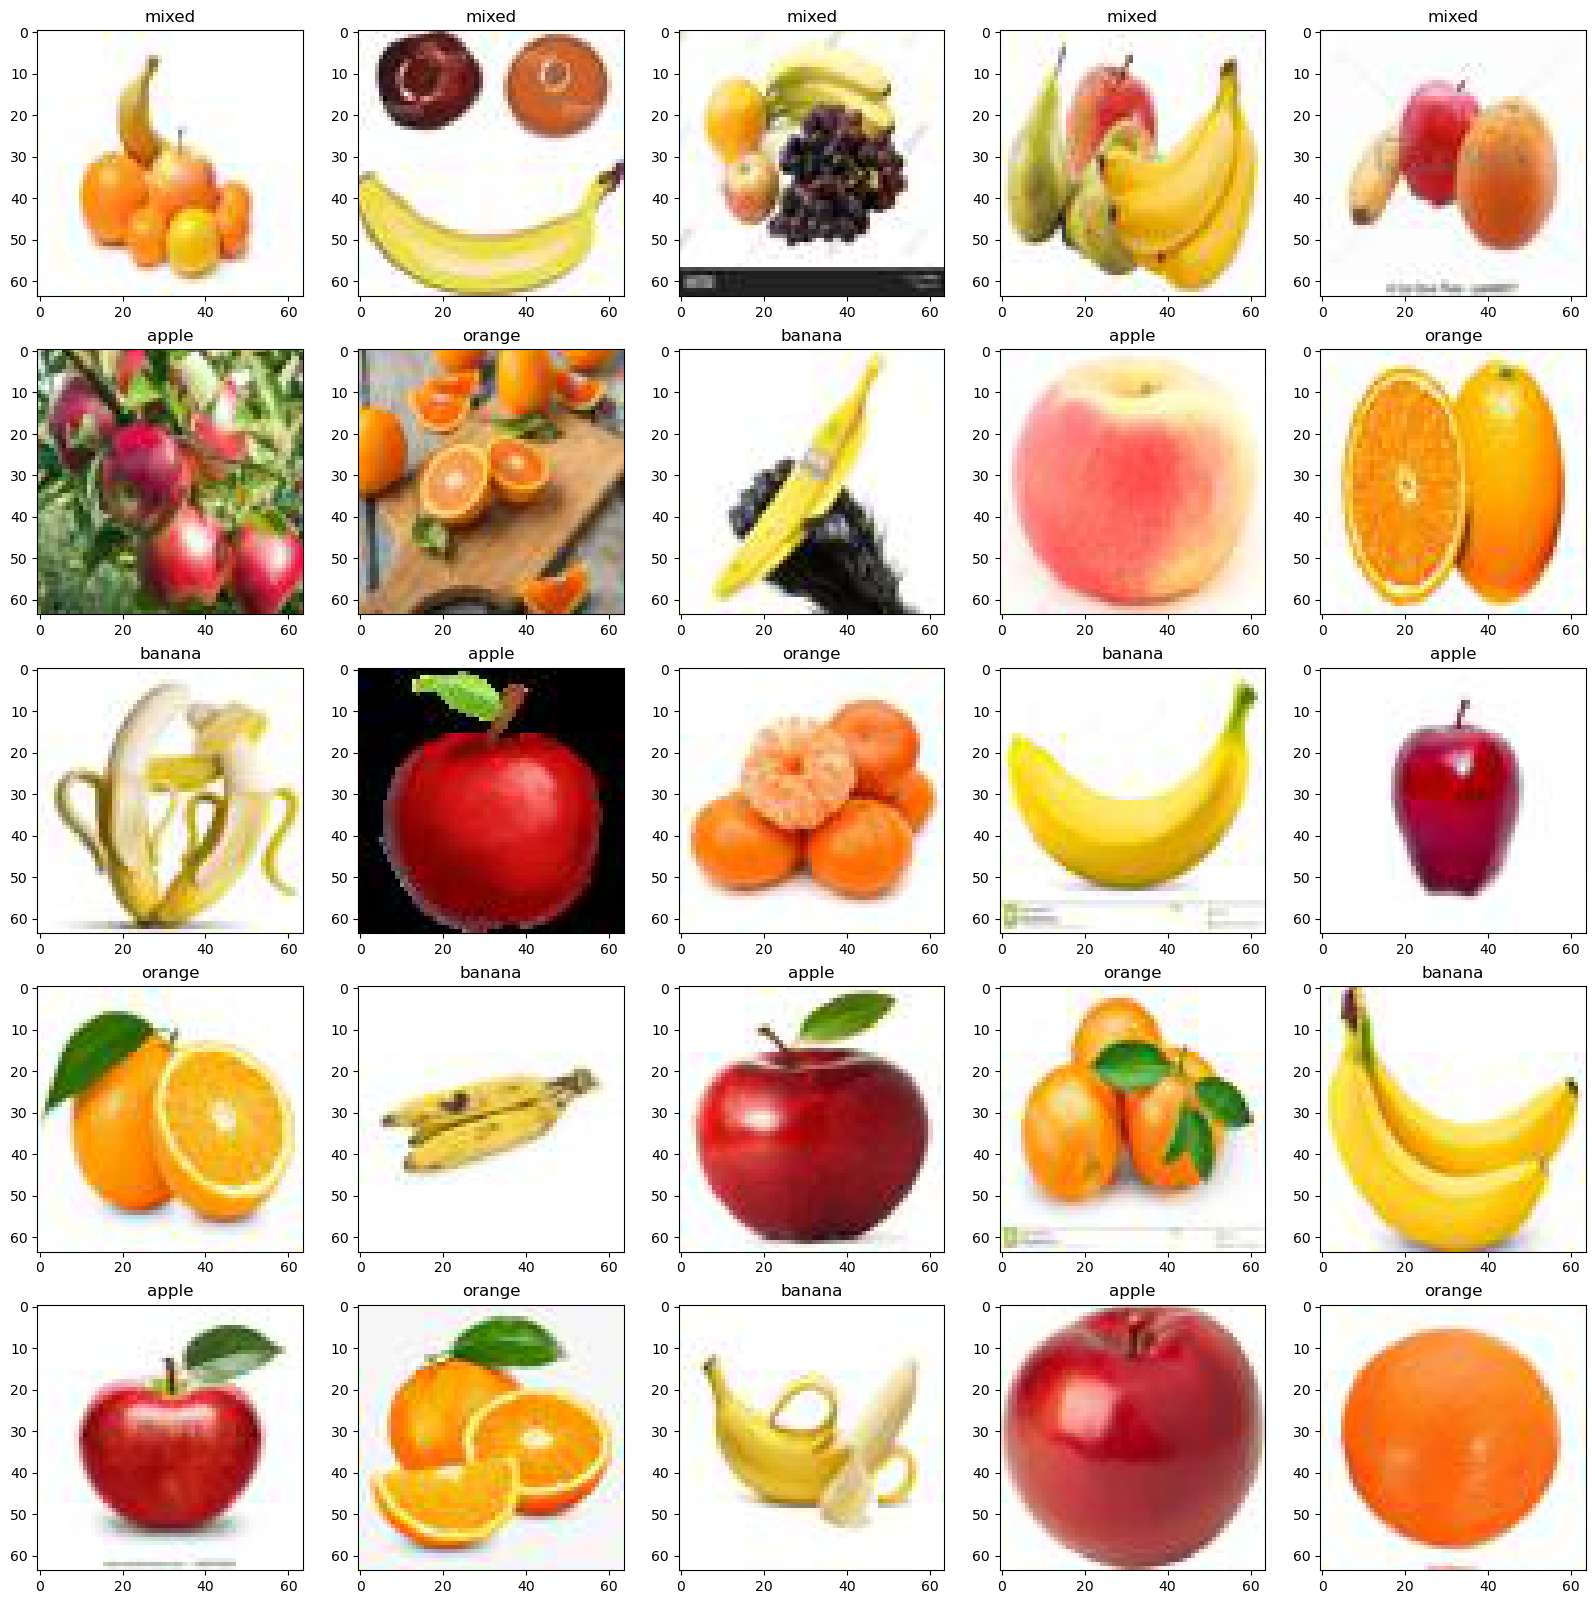

In [55]:
# preview of test images
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(test_img[i])
    plt.title(test_class[i])
plt.show()

In [56]:
train = np.array(train_img)
train_labels = np.array(train_class)
test = np.array(test_img)
test_labels = np.array(test_class)

In [57]:
print(train.shape)
print(train_labels.shape)
print(test.shape)
print(test_labels.shape)

(240, 64, 64, 3)
(240,)
(60, 64, 64, 3)
(60,)


In [58]:
from sklearn.preprocessing import LabelEncoder
# unable to use keras' encoder as it only works for ints.
# use sklearn instead
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.fit_transform(test_labels)
# try out with one hot encoding

In [59]:
# normalize
train = train/255
test = test/255

c. Build the model
==

In [76]:
# accuracy 20% only
# loss getting worse
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(3,3),
                                 activation='relu',
                                 input_shape=(64,64,3)))
model.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=(5,5),
                                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
model.add(tf.keras.layers.Dropout(rate=0.2))
# flatten layer into 1d before sending to dense
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(units=256, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(units=len(class_names), activation='softmax'))

In [77]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [78]:
hist = model.fit(train, train_labels, batch_size=10, epochs=50)


Epoch 1/50
 1/24 [>.............................] - ETA: 4s - loss: 1.5135 - accuracy: 0.1000

/Users/xinyitay/miniforge3/envs/gdiptf/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


24/24 [==============================] - 0s 13ms/step - loss: 1.2534 - accuracy: 0.5083
Epoch 2/50
24/24 [==============================] - 0s 12ms/step - loss: 0.8805 - accuracy: 0.6958

d. Test our model
==

Observe the loss and accuracy over training

In [79]:
loss, accuracy = model.evaluate(test,test_labels)

print(loss)
print(accuracy)

2/2 [==============================] - 0s 26ms/step - loss: 0.7980 - accuracy: 0.8833
0.7980263233184814
0.8833333849906921


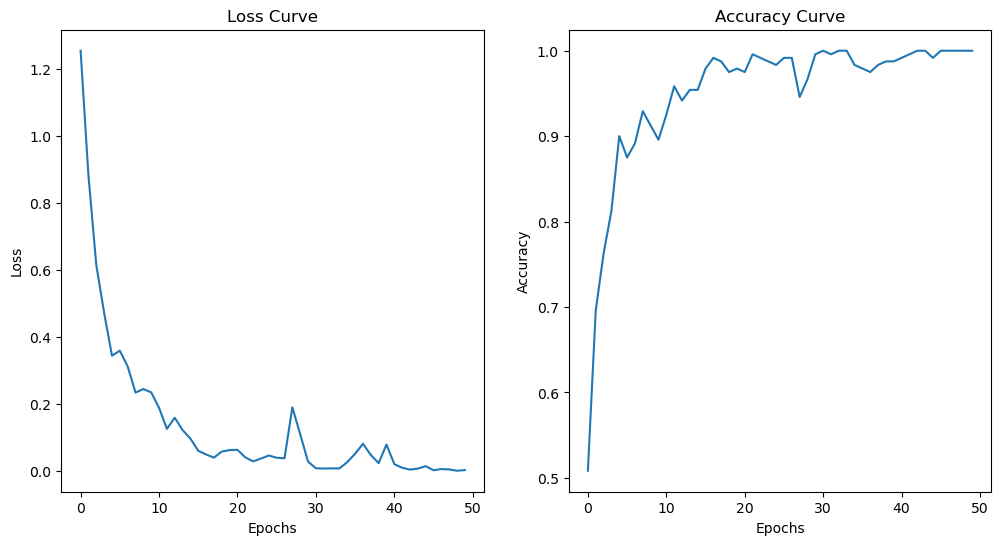

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt
ax[0].plot(hist.history['loss'])
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curve')

ax[1].plot(hist.history['accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Curve')

plt.show()

In [81]:
predictions = model.predict(test)


e. Plot images with labels to show accuracy of predictions
==
1. Define function to plot image
2. Define function to plot bar chart to show relative probabilities


In [82]:
def plot_image(i, pred, true_label, img_arr):
    plt.grid(False)
    plt.imshow(img_arr[i])

    pred_label = np.argmax(pred[i])

    if pred_label == true_label[i]:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("predicted: {} {:2.0f}% (actual: {})".format(class_names[pred_label],
                                                           100*np.max(pred[i]),
                                                           class_names[true_label[i]]),
                                                           color=color)

In [94]:
def plot_probs(i, pred, true_label):
    plt.xticks(range(4), class_names, rotation=45)
    # cannot take argmax, must take other indices also. EXCEPT the pred.
    # abit inefficient time wise
    pred_arr = np.arange(0,4,1)
    pred_arr = np.delete(pred_arr, true_label[i])
    #pred_label = np.setdiff1d(pred[i],true_label[i])
    # pred_label = np.argmax(pred[i])
    plot = plt.bar(range(4),pred[i])
    plt.ylim([0,1])

    for label in pred_arr:
        plot[label].set_color('red')
    plot[true_label[i]].set_color('green')

3. Plot test images with labels and probabilities of prediction

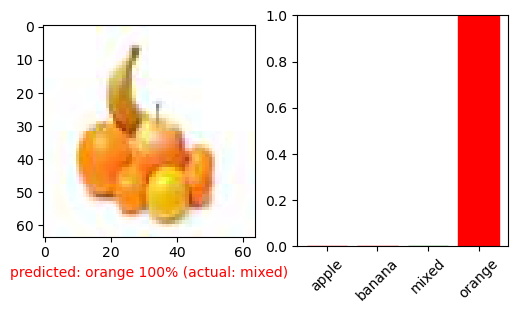

In [95]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(0, predictions, test_labels, test)
plt.subplot(1,2,2)
plot_probs(0, predictions, test_labels)
plt.show()



In [96]:
num_rows = 10
num_cols = 6

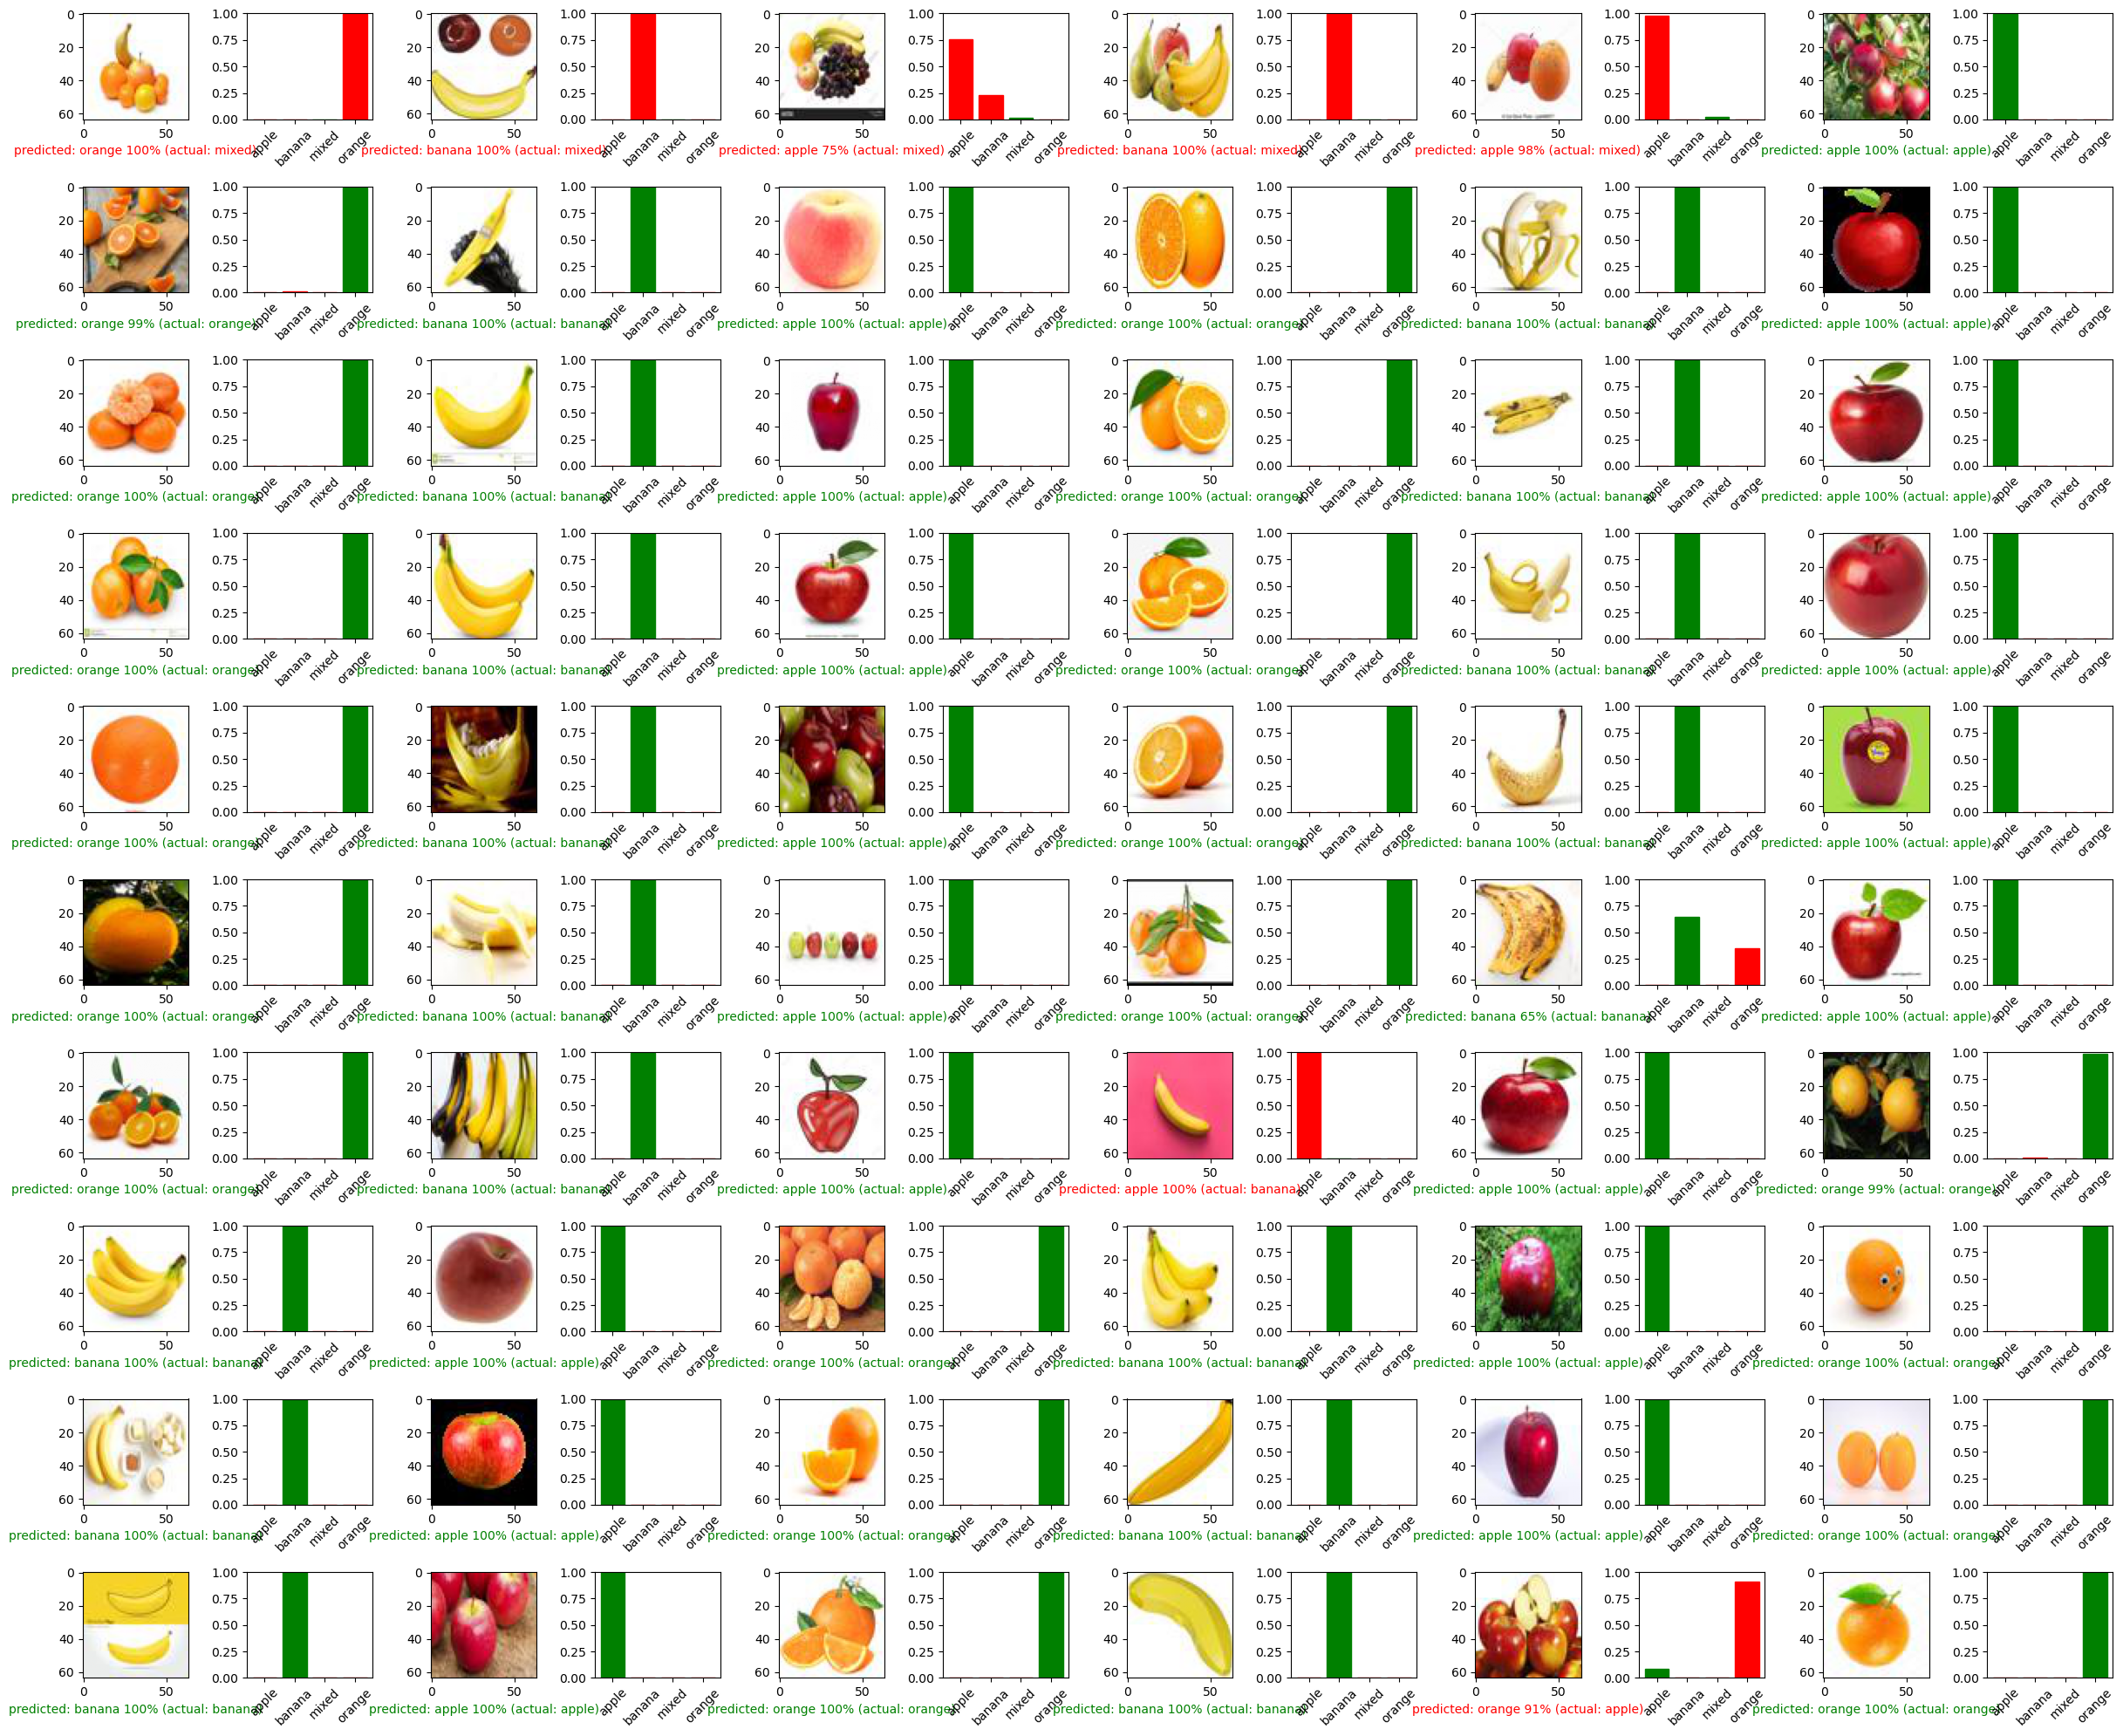

In [98]:
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_probs(i, predictions, test_labels)
plt.tight_layout()
plt.show()

#looks like they learn from color
# image augmentation: mb change rgb hues

In [99]:
#explore early stopping, pipeline